- 保监会 分类模型 2 训练 

# 基本设置

In [1]:
##load packages, needed
# encoding=utf-8

import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict

import pickle

%matplotlib inline
import numpy as np
import pandas as pd
import pre_cor_b
# import dict_dbutils
import os
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from pandas.io import sql
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.899 seconds.
Prefix dict has been built succesfully.


In [2]:
def set_ch():
    '''
    功能：设定绘图时显示中文
    '''	
    from pylab import mpl
    mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题
set_ch()

In [3]:
class StatsFeatures_cor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.neg = set()
        f = open("corpus/neg_words_20180704.txt","r+", encoding='UTF-8')
        for content in f:
            self.neg.add(content.strip())
        f.close()
        
        self.company = set() # 公司
        f = open("corpus/bank_company_20180814.txt","r+", encoding='UTF-8')
        for content in f:
            self.company.add(content.strip())
        f.close()

        self.regulators = set() # 监管机构及领导
        f = open("corpus/bank_regulators_20180815.txt","r+", encoding='UTF-8')
        for content in f:
            self.regulators.add(content.strip())
        f.close()    
        
        #初始化字典liwc
        self.liwc = {} 
        f2 = open("corpus/scliwc.txt",'r', encoding = 'gb18030')
        for ii in f2:     #ii在scliwc.txt中循环
            i = ii.strip().split() 
            self.liwc[i[0]] = i[1:len(i)]
        f2.close      
        
        self.category = set()
        for i in list(self.liwc.values()):
            for j in i:
                self.category.add(j)         
        
    def fit(self, X, y=None):
        return self

    def getcnt(self,x):        
        return len(list(set(x)))

    def getnegcnt(self,x):
        negcnt = 0
        words = x.split()
        for w in words:
            if w in self.neg:
                negcnt = negcnt+1
        return negcnt
    
    def getorgcnttf(self,x):
        companycnt=0
        companytf=0
        regcnt = 0
        regtf = 0
        
        words = x.split()
        words_set=set(words)
        for w in words_set:
            if w in self.company:
                companycnt = companycnt+1
                companytf=companytf+words.count(w)
                
            if w in self.regulators:
                regcnt = regcnt+1
                regtf=regtf+words.count(w)            
                
        return companycnt, companytf, regcnt, regtf
    
    def transform(self, X):
        data = []
        for x in X:
            if len(x) == 0:
                length  = 1
            else :
                length = len(x)
                
            companycnt, companytf, regcnt, regtf=self.getorgcnttf(x)
            
            words = x.split()
            psy = []
            for w in words:
                if w in self.liwc: #是否liwc字典包含分词结果列表words的哪些分词
                    psy += self.liwc[w] 
            
            cat_tf = []
            for cat in self.category:
                cat_tf.append(psy.count(cat)) 
                
            data.append([len(x),self.getcnt(x),self.getcnt(x)/length,
                         self.getnegcnt(x),self.getnegcnt(x)/length,
                         companycnt, companytf, regcnt, regtf] + cat_tf)            
        return data

In [4]:
def getkeywords(X, N = 1000):
    '''
    训练时生成，合并所有记录，取N个关键词
    '''
    textrank = analyse.textrank

    text_combined = ' '.join(X)
    keywords = textrank(text_combined, topK = N)
    print('keywords num: ', len(keywords))
    if len(keywords) < N : 
        N  = len(keywords)

    if keywords:
        f = open("corpus/keywords.txt","w+", encoding='UTF-8')
        for content in keywords:
            content = content.strip()
            f.write(content + '\n')
        f.close()

In [5]:
class Statskeywords(BaseEstimator, TransformerMixin):
    
    def __init__(self, topk = 100):
        self.topk = topk
        
        self.keywords = set()
        f = open("corpus/keywords.txt","r+", encoding='UTF-8')
        num = 0
        for content in f:
            if num < topk:
                self.keywords.add(content.strip().replace('\n', ''))
            num += 1
        f.close() 
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        '''
        文本中关键词的词频
        '''                        
        data = []
        for x in X:
            words = x.split()
            word_tf = []
            keycnt = 0
            for kw in self.keywords:
                word_tf.append(words.count(kw)) # 各个关键词的词频
                if kw in words:keycnt+=1
            word_tf.append(keycnt) # 关键词的个数             
                
            data.append(word_tf)       
            
        return data        

## 上一版模型读入

In [6]:
# 上一版模型
from sklearn.externals import joblib
pipeline_old = joblib.load( "model/cbrc_8classifier_0814.pkl.z") 

# 导入数据

In [7]:
title = []
filename = 'data/titles0.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    title.append(f.strip().replace('\n', ''))
fid.close()
print(len(title))

2392


In [8]:
title[:2]

['小白学 保险 基础 篇 买好 宝宝 保险 第一步 该 做', '过 诉讼时效 债务 如何 处理 最高法院 答复 全']

In [9]:
content = []
filename = 'data/contents0.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    content.append(f.strip().replace('\n', ''))
fid.close()
print(len(content))
# content[:2]

2392


In [10]:
title_content = [t + ' ' + c for t,c in zip(title, content)]
print(len(title_content))

2392


In [11]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [12]:
label = []
filename = 'data/labels.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    label.append(f.strip().replace('\n', ''))
fid.close()
print(len(label))
label[:5]

2392


['噪音', '噪音', '噪音', '噪音', '噪音']

In [13]:
label = [label_dic[l] for l in label]
label[:5]

[8, 8, 8, 8, 8]

# 训练模型

## 分割训练集、测试集

In [14]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 1674
训练集-各类数量： Counter({2: 671, 8: 551, 3: 89, 7: 78, 5: 77, 1: 73, 4: 71, 6: 64})
测试集： 718
测试集-各类数量： Counter({2: 275, 8: 249, 6: 39, 4: 36, 3: 36, 5: 30, 1: 27, 7: 26})


# xgboost

## feature

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2", 8)

In [15]:
def plot2(features):
    % matplotlib inline

    f = plt.figure(figsize=(15, 9))
    ax = f.add_subplot(111)

    for i in range(1,9):
        ax.scatter(features[features['label']==i]['f1'],
                   features[features['label']==i]['f2'],
                   color=colors[i-1], label=i, alpha=.8) 
    
    ax.set_title("Truncated SVD, 2 Components")    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    print(class_name_dict)
    
    plt.show()

In [16]:
def plot3(features):    
    % matplotlib notebook

    f = plt.figure(figsize=(15, 9))
    ax = f.add_subplot(111, projection='3d')  # 创建一个三维的绘图工程

    for i in range(1,9):
        ax.scatter(features[features['label']==i]['f1'],
                   features[features['label']==i]['f2'],
                   features[features['label']==i]['f3'],
                   color=colors[i-1], label=i, alpha=.8)

    ax.set_zlabel('f3')  # 坐标轴
    ax.set_ylabel('f2')
    ax.set_xlabel('f1')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    print(class_name_dict)

    plt.show()

In [17]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

## 计算特征

### scaled

In [24]:
combined_features = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
       ('len_stats', StatsFeatures_cor())
    ])),
   ('standard', StandardScaler(with_mean=False))
])

X_features = combined_features.fit(X_train, y_train).transform(X_train)
# print(X_features)

X_features_dense = DenseTransformer().fit_transform(X_features)
print(X_features_dense.shape)
print(type(X_features_dense))
# X_features_dense[:,0].shape
X_features_dense[:5,:5]

(567, 2580)
<class 'numpy.matrixlib.defmatrix.matrix'>


matrix([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 7.40258238, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [25]:
X_features_dense[:5,:20]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 7.40258238, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        

### unscaled

In [26]:
combined_features_unscaled = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
       ('len_stats', StatsFeatures_cor())
    ])),
   # ('standard', StandardScaler(with_mean=False))
])

X_features_unscaled = combined_features_unscaled.fit(X_train, y_train).transform(X_train)
# print(X_features)

X_features_dense_unscaled = DenseTransformer().fit_transform(X_features_unscaled)
print(X_features_dense_unscaled.shape)
print(type(X_features_dense_unscaled))
X_features_dense_unscaled[:5,:20]

(567, 2580)
<class 'numpy.matrixlib.defmatrix.matrix'>


matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.15165469, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        

In [27]:
X_features_dense_unscaled[:5,:20]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.15165469, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        

## 特征可视化

### TruncatedSVD, SparsePCA, PCA

#### scaled

In [28]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 3) # 处理稀疏数据
feature_tsvd = tsvd.fit_transform(X_features)
print('-- TruncatedSVD: ')
print("各维度的方差值: ", tsvd.explained_variance_)
print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd.shape)
print()
pca = PCA(n_components = 3, whiten = True)
feature_pca = pca.fit_transform(X_features_dense)
print('-- PCA: ')
print("各维度的方差值: ", pca.explained_variance_)
print("各维度的方差值占总方差值的比例: ", pca.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(pca.explained_variance_ratio_))
feature_pca

-- TruncatedSVD: 
各维度的方差值:  [65.90551999 47.34624181 43.60411017]
各维度的方差值占总方差值的比例:  [0.02557451 0.01837262 0.01692049]
各维度的方差值之和占总方差值的比例:  0.06086762590764956
(567, 3)

-- PCA: 
各维度的方差值:  [84.04984888 45.57130044 43.15143263]
各维度的方差值占总方差值的比例:  [0.03255786 0.01765267 0.0167153 ]
各维度的方差值之和占总方差值的比例:  0.06692583174338551


array([[-0.39798412,  0.24826097,  0.59442997],
       [-0.56466802,  0.4754075 ,  0.24426766],
       [ 0.47852014, -1.01584858, -0.48314511],
       ...,
       [ 0.25230984, -0.2721331 ,  0.06639314],
       [-0.44428004,  0.28830186,  0.51534175],
       [-0.38473684,  0.37131097,  0.20073634]])

         f1        f2        f3  label
0 -0.397984  0.248261  0.594430      6
1 -0.564668  0.475408  0.244268      5
2  0.478520 -1.015849 -0.483145      4
3  0.618448 -1.568054 -0.754836      2
4 -0.359007  0.315619 -0.044461      3
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


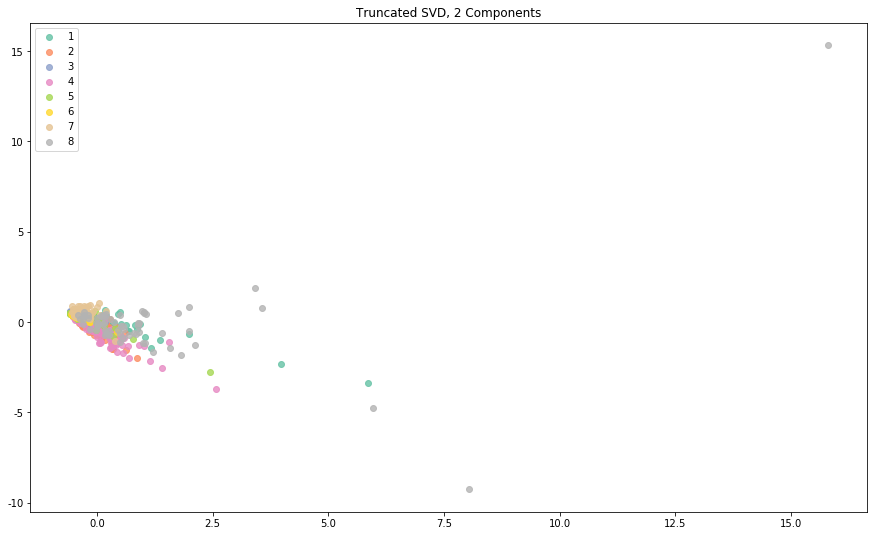

In [50]:
features = pd.DataFrame(feature_pca, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


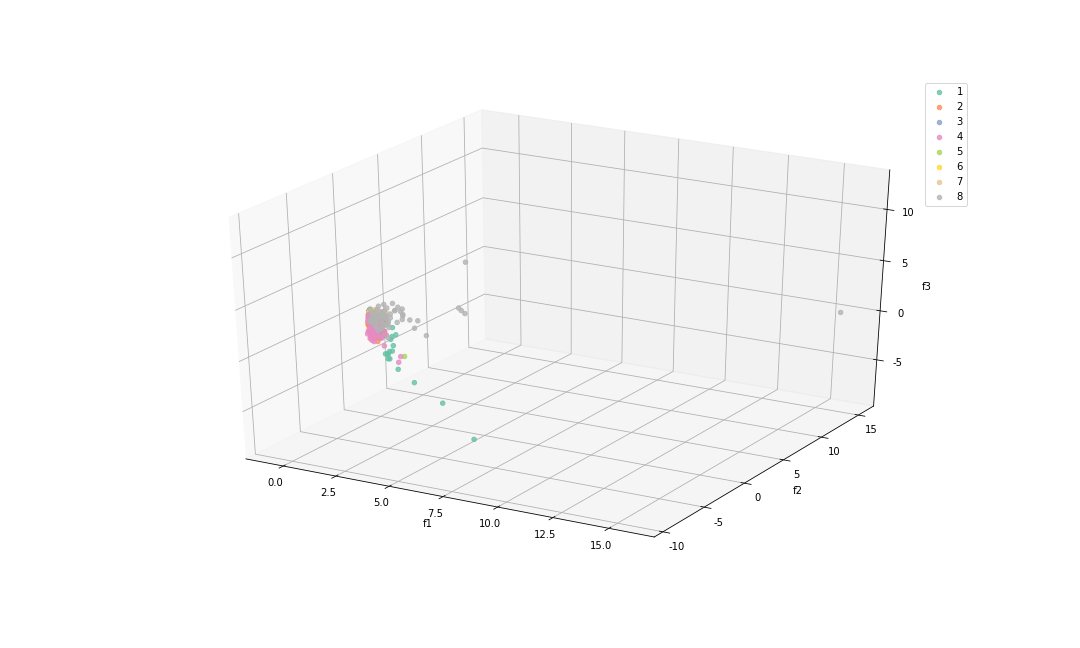

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [51]:
plot3(features)

#### unscaled

In [31]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 3) # 处理稀疏数据
feature_tsvd_unscaled = tsvd.fit_transform(X_features_unscaled)
print('-- TruncatedSVD: ')
print("各维度的方差值: ", tsvd.explained_variance_)
print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd_unscaled.shape)
print()
pca = PCA(n_components = 3, whiten = True)
feature_pca_unscaled = pca.fit_transform(X_features_dense_unscaled)
print('-- PCA: ')
print("各维度的方差值: ", pca.explained_variance_)
print("各维度的方差值占总方差值的比例: ", pca.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(pca.explained_variance_ratio_))
feature_pca_unscaled

-- TruncatedSVD: 
各维度的方差值:  [4737893.51556018   18122.61359753    4919.35927301]
各维度的方差值占总方差值的比例:  [0.99377281 0.00380122 0.00103184]
各维度的方差值之和占总方差值的比例:  0.9986058628917894
(567, 3)

-- PCA: 
各维度的方差值:  [4.75147618e+06 1.32555885e+04 4.65225831e+03]
各维度的方差值占总方差值的比例:  [9.94864063e-01 2.77545507e-03 9.74089826e-04]
各维度的方差值之和占总方差值的比例:  0.9986136075202788


array([[-0.48614003,  0.85318735,  0.47013587],
       [-0.54782907,  0.79015344,  0.28386625],
       [ 0.72053564, -0.88374124,  0.48491595],
       ...,
       [ 0.24827796, -1.03870357, -0.04526858],
       [-0.54017032,  0.97596379,  0.41739982],
       [-0.44816283,  0.85875809,  0.28215153]])

         f1        f2        f3  label
0 -0.486140  0.853187  0.470136      6
1 -0.547829  0.790153  0.283866      5
2  0.720536 -0.883741  0.484916      4
3  0.812981 -0.745317  0.473983      2
4 -0.454012  0.340552 -0.057455      3
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


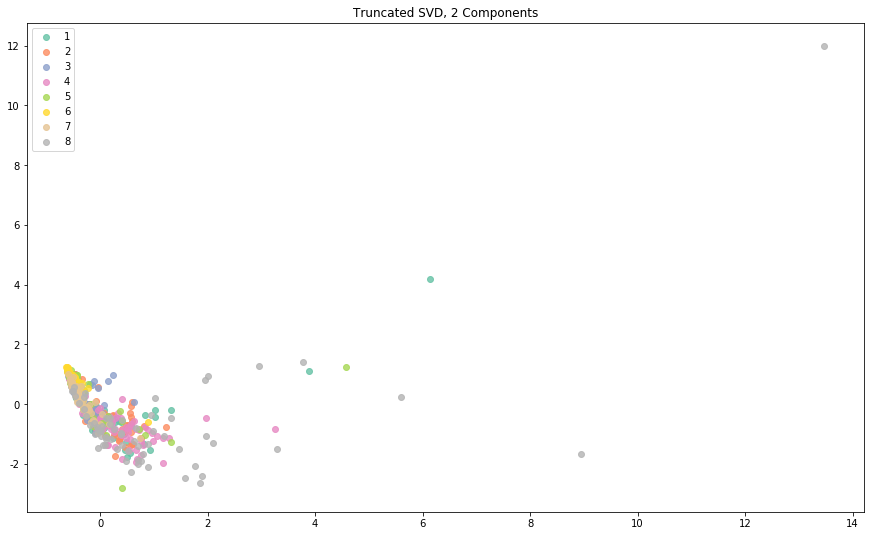

In [52]:
features = pd.DataFrame(feature_pca_unscaled, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


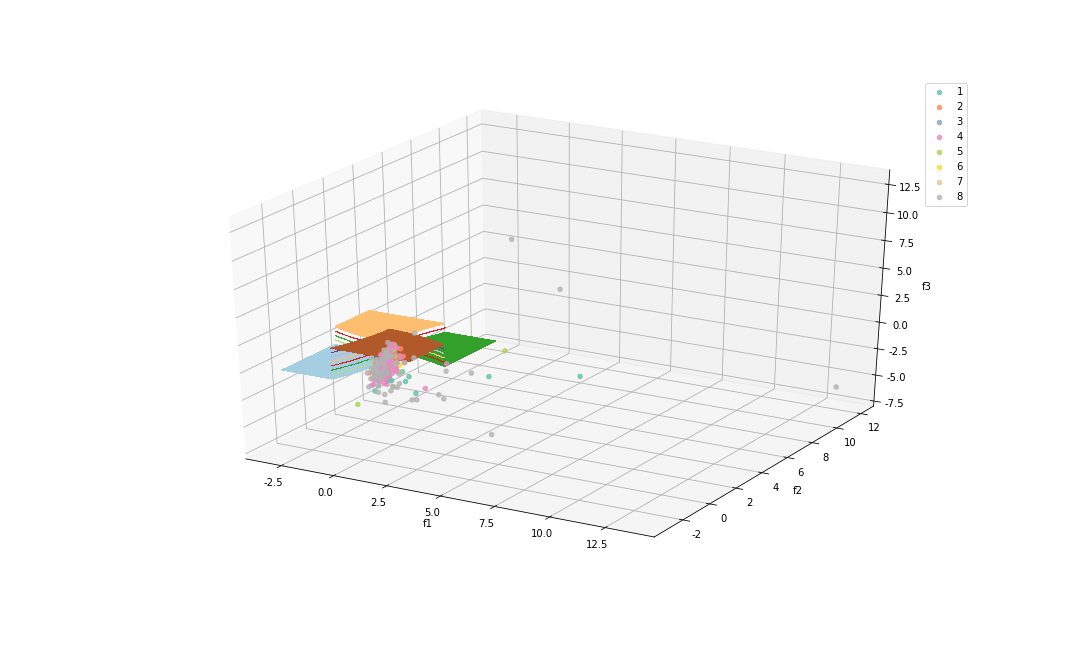

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [53]:
plot3(features)

### lda

#### scaled

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_features_dense, y_train)
feature_lda = lda.transform(X_features_dense)

print('-- lda: ')
print(feature_lda.shape)
# print("截距: ", lda.intercept_)
# print("系数: ", lda.coef_)
print("各维度的方差值占总方差值的比例: ", lda.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(lda.explained_variance_ratio_))
feature_lda

-- lda: 
(567, 3)
各维度的方差值占总方差值的比例:  [0.22160209 0.18459605 0.15493635]
各维度的方差值之和占总方差值的比例:  0.5611344897066132


array([[ 3.5049519 ,  0.19376027,  1.29902887],
       [-0.0981677 ,  2.33628125,  1.69720345],
       [-1.26299532, -0.43751628,  1.34132727],
       ...,
       [-1.52401353, -0.30410587,  1.23574845],
       [ 4.48614382,  1.69878231,  2.22686841],
       [ 2.10759597, -0.31156358,  0.07492012]])

         f1        f2        f3  label
0  3.504952  0.193760  1.299029      6
1 -0.098168  2.336281  1.697203      5
2 -1.262995 -0.437516  1.341327      4
3 -2.508531  0.265144  1.308065      2
4 -0.049578  1.952446  0.080662      3
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


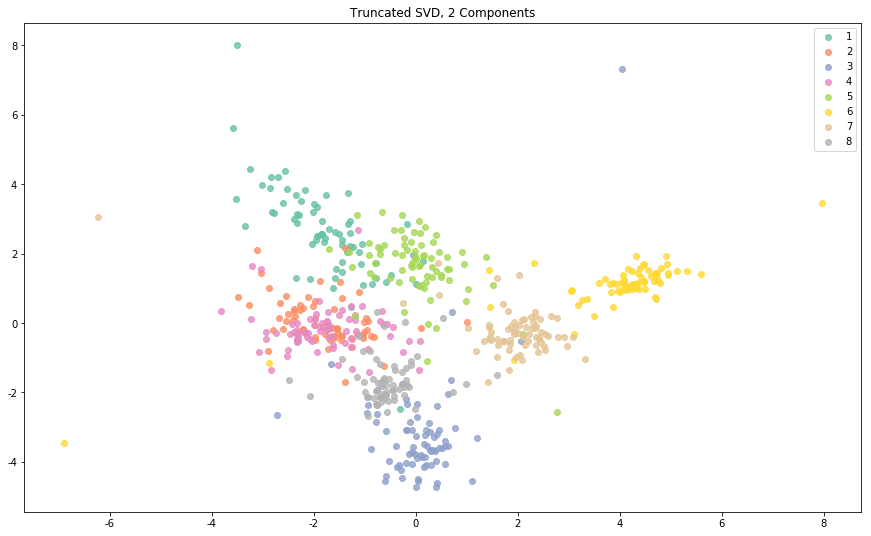

In [45]:
features = pd.DataFrame(feature_lda, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


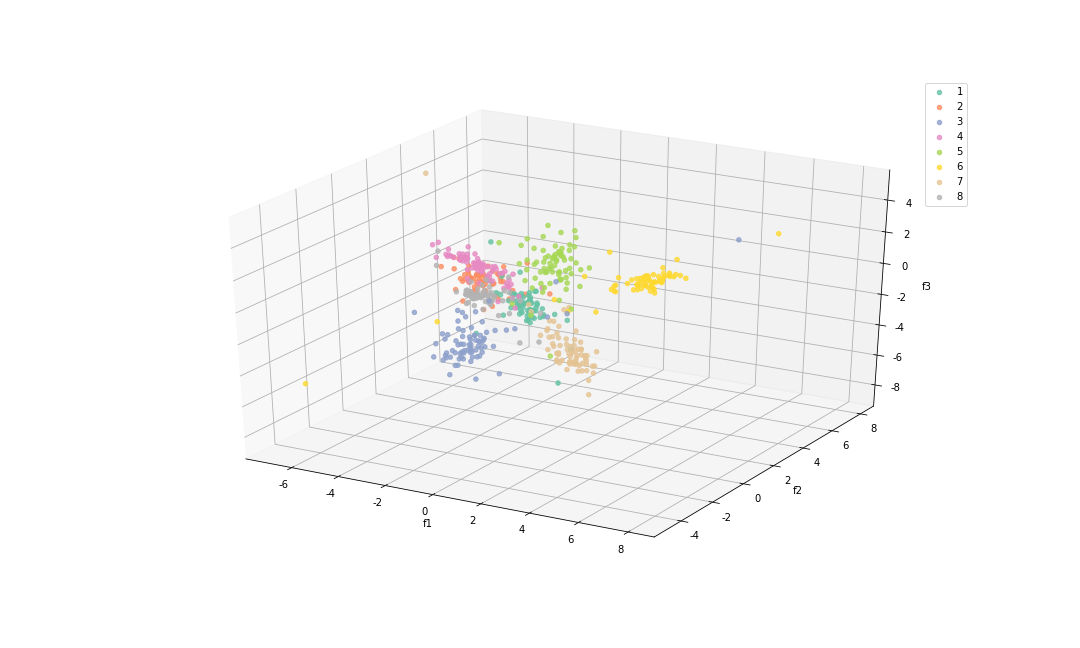

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [47]:
plot3(features)

#### unscaled

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_features_dense_unscaled, y_train)
feature_lda_unscaled = lda.transform(X_features_dense_unscaled)

print('-- lda: ')
print(feature_lda_unscaled.shape)
# print("截距: ", lda.intercept_)
# print("系数: ", lda.coef_)
print("各维度的方差值占总方差值的比例: ", lda.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(lda.explained_variance_ratio_))
feature_lda_unscaled

-- lda: 
(567, 3)
各维度的方差值占总方差值的比例:  [0.22160209 0.18459605 0.15493635]
各维度的方差值之和占总方差值的比例:  0.5611344897066136


array([[ 3.5049519 ,  0.19376027,  1.29902887],
       [-0.0981677 ,  2.33628125,  1.69720345],
       [-1.26299532, -0.43751628,  1.34132727],
       ...,
       [-1.52401353, -0.30410587,  1.23574845],
       [ 4.48614382,  1.69878231,  2.22686841],
       [ 2.10759597, -0.31156358,  0.07492012]])

         f1        f2        f3  label
0  3.504952  0.193760  1.299029      6
1 -0.098168  2.336281  1.697203      5
2 -1.262995 -0.437516  1.341327      4
3 -2.508531  0.265144  1.308065      2
4 -0.049578  1.952446  0.080662      3
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


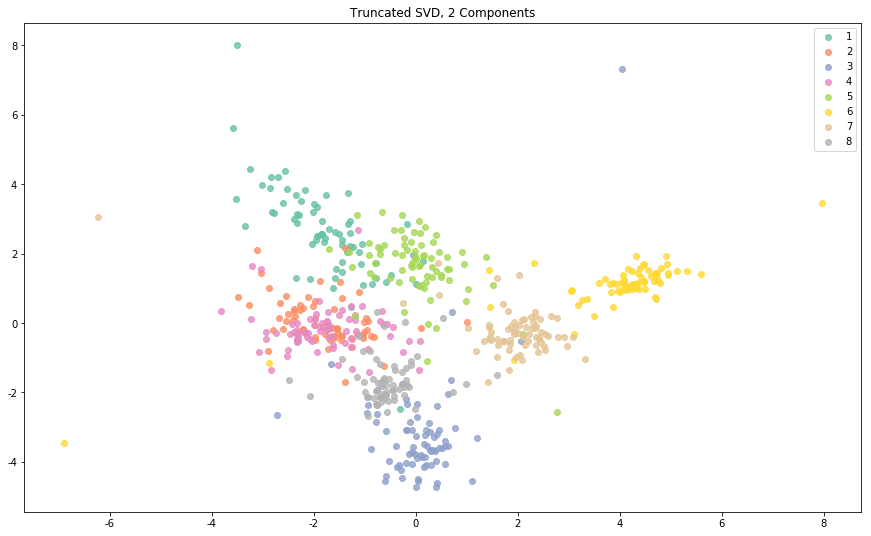

In [48]:
features = pd.DataFrame(feature_lda_unscaled, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


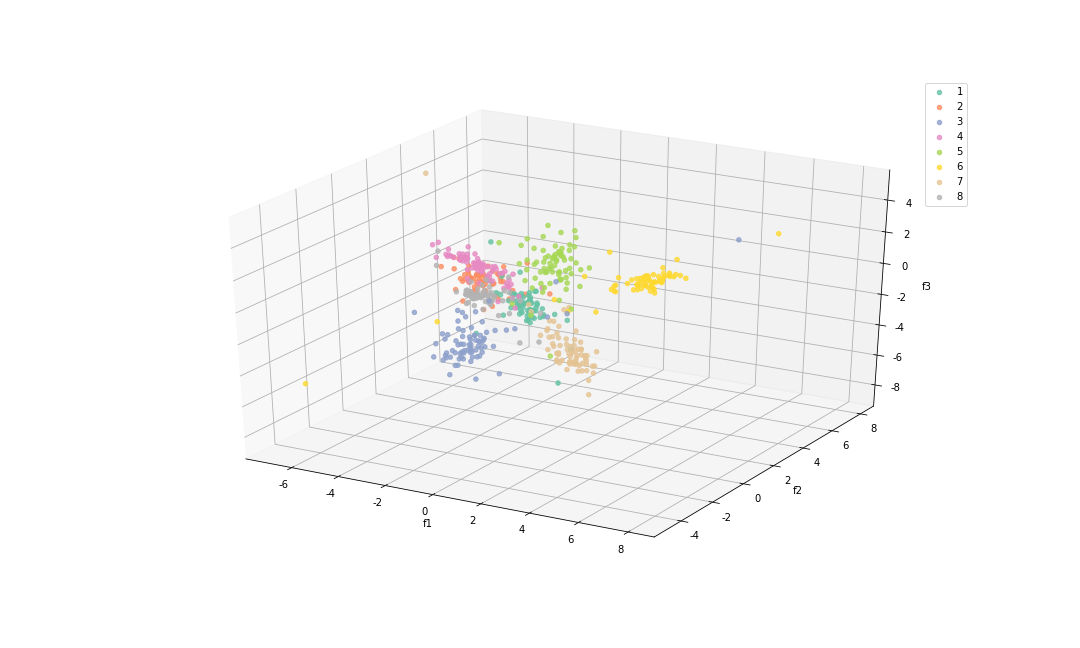

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [49]:
plot3(features)

## 特征重要性

In [137]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [138]:
feat_names = [str(i) for i in range(9)]
get_xgb_imp(pipeline,feat_names)

AttributeError: 'Pipeline' object has no attribute 'booster'

In [139]:
from xgboost import plot_importance

ValueError: tree must be Booster, XGBModel or dict instance

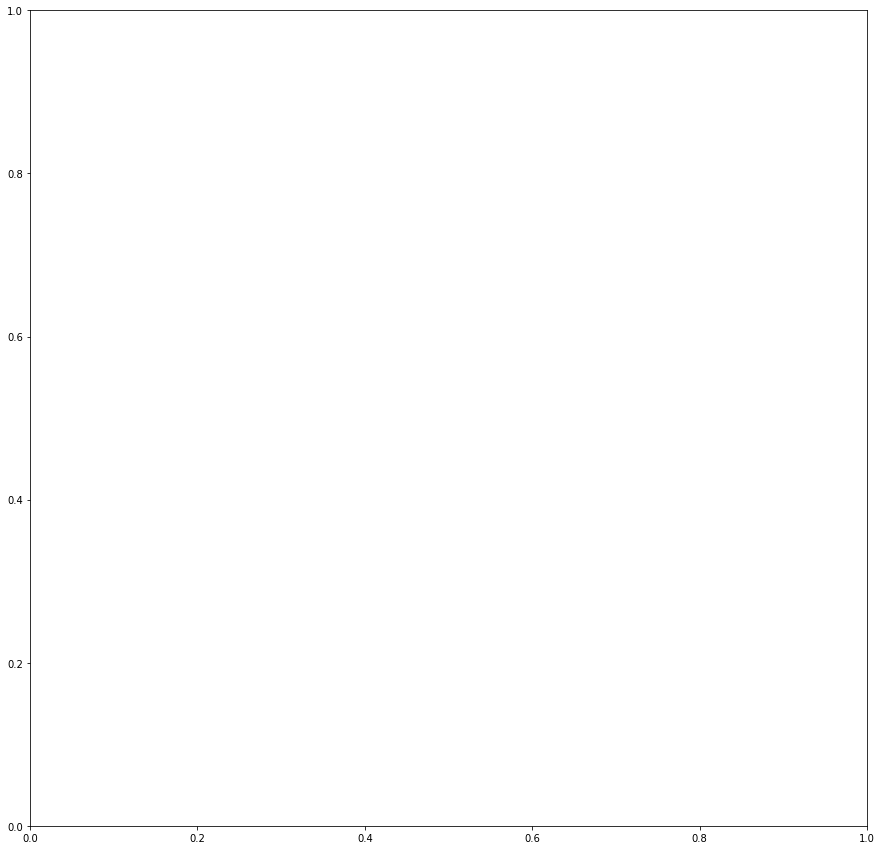

In [141]:
%matplotlib inline

fig,ax = plt.subplots(figsize=(15,15))
plot_importance(Pipeline,
                 height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

## train

In [15]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', StatsFeatures_cor()),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=50))])),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

1.0


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

## test

In [16]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8774373259052924
             precision    recall  f1-score   support

          1       0.65      0.56      0.60        27
          2       0.86      0.95      0.90       275
          3       0.78      0.69      0.74        36
          4       0.84      0.44      0.58        36
          5       0.90      0.63      0.75        30
          6       0.92      0.85      0.88        39
          7       0.77      0.77      0.77        26
          8       0.93      0.97      0.95       249

avg / total       0.88      0.88      0.87       718

confusion_matrix: 
[[ 15  12   0   0   0   0   0   0]
 [  6 260   3   0   1   0   0   5]
 [  0   4  25   0   0   0   4   3]
 [  0  14   0  16   0   2   0   4]
 [  1   4   0   3  19   1   0   2]
 [  0   1   1   0   1  33   2   1]
 [  1   2   1   0   0   0  20   2]
 [  0   5   2   0   0   0   0 242]]


In [44]:
# 上一版模型 
# y_pred_class = pipeline_old.predict(X_test)
# print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
# print(metrics.classification_report(y_test, y_pred_class))
# print('confusion_matrix: ')
# print( metrics.confusion_matrix(y_test, y_pred_class))

## PRC and ROC

In [97]:
from sklearn.preprocessing import label_binarize, OneHotEncoder

X = np.array(title_content)
Y = np.array(label)

# Use label_binarize to be multi-label like settings
# Y = label_binarize(label, classes=range(1,9))
# n_classes = Y.shape[1]
# print(n_classes)

Y = OneHotEncoder(sparse = False).fit_transform(Y.reshape(-1,1))

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [98]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [91]:
print(Y.shape)
Y

(811, 8)


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [99]:
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', StatsFeatures_cor()),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=50))])),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', OneVsRestClassifier(XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8)))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline)

# y_score = pipeline.decision_function(X_test)

1.0
Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          n_jobs=1))])


In [101]:
y_pred_class = pipeline.predict(X_test)

test_auc2 = metrics.roc_auc_score(y_test,y_pred_class)#验证集上的auc值
print ("xgb_muliclass_auc:",test_auc2)

xgb_muliclass_auc: 0.8272382451473275


In [102]:
y_pred_class

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

### PRC

In [79]:
# The average precision score in multi-label settings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# Plot the micro-averaged Precision-Recall curve
% matplotlib inline
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [ ]:
# Plot Precision-Recall curve for each class and iso-f1 curves
% matplotlib inline
from itertools import cycle
import seaborn as sns

colors = sns.color_palette("Set2", 8)
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()

### ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Plot of a ROC curve for a specific class

% matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot ROC curves for the multiclass problem
# Compute macro-average ROC curve and ROC area

% matplotlib inline
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## 模型解释

## KFold

In [5]:
cir_data_raw = pd.read_excel('data/result/title_content_label.xlsx')
raw_title = np.array(cir_data_raw['title'])
raw_content = np.array(cir_data_raw['content'])
print(cir_data_raw.shape)
cir_data_raw.head()

(10530, 5)


,title,content,label,title_content,index
0,做好规划不当月光族不做守财奴,一一妈妈说理财·出品\n (图片)\n\r月光族困惑：···这个月才过半，各种经费不够啊！...,噪音,做好规划不当月光族不做守财奴。 一一妈妈说理财·出品\n (图片)\n\r月光族困惑：···...,0
1,做车险代理的前景如何 谊信合让你的财富事业迈上新高度,小本创业网\n\r»\n\r加盟项目资讯›\n\r»\n\r资讯中心\n\r»\n\r做车...,噪音,做车险代理的前景如何 谊信合让你的财富事业迈上新高度。 小本创业网\n\r»\n\r加盟项目...,1
2,坐飞机必须买保险？航意险适合哪些人？,坐飞机必须买保险？航意险适合哪些人？\n\r 随着经济的发展，大家对生活品质的追求，越来...,产品销售,坐飞机必须买保险？航意险适合哪些人？。 坐飞机必须买保险？航意险适合哪些人？\n\r 随着...,2
3,左权县人民政府金融工作办公室2017年统筹整合财政资金项目公示,\n\r为推进我县\n“五位一体”扶贫小额信贷工作，各承贷银行对全县建档立卡贫困户累计备案...,噪音,左权县人民政府金融工作办公室2017年统筹整合财政资金项目公示。 \n\r为推进我县\n“五...,3
4,昨天车险报案比平常翻倍,(图片)\n\r雪中骑行滑倒 朱小军 摄\n\r 一场暴雪让扬州各家保险公司忙翻了天，车...,消费服务,昨天车险报案比平常翻倍。 (图片)\n\r雪中骑行滑倒 朱小军 摄\n\r 一场暴雪让扬州...,4


In [63]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=0)
title_content = np.array(title_content)
label = np.array(label)

In [64]:
kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 'predict_label':[], 'title_content':[]}
kfold_res

{'raw_title': [],
 'raw_content': [],
 'label': [],
 'predict_label': [],
 'title_content': []}

In [65]:
num = 0
for train_index , test_index in kf.split(title_content):
    print('---- %s'%(num+1))
    X_train,X_test = title_content[train_index], title_content[test_index]
    y_train,y_test = label[train_index], label[test_index]
    
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tf_idf', Pipeline([
                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                ('tf_idf', TfidfTransformer()),
                ('chi', SelectKBest(chi2, k=20000))
            ])),
            ('tf', Statskeywords(topk = 1000)),
            ('len_stats', StatsFeatures_cor())
        ])),
        ('standard', StandardScaler(with_mean=False)),
        ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
    ])
    pipeline.fit(X_train, y_train)
    print(pipeline.score(X_train, y_train))    
    
    y_pred_class = pipeline.predict(X_test)
    print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
    print(metrics.classification_report(y_test, y_pred_class))
    print('confusion_matrix: ')
    print( metrics.confusion_matrix(y_test, y_pred_class))    
    
    kfold_res['raw_title'] += list(raw_title[test_index])
    kfold_res['raw_content'] += list(raw_content[test_index])
    kfold_res['title_content'] += list(X_test)
    kfold_res['label'] += [class_name_dict[i] for i in y_test]
    kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
    
    num += 1

---- 1
0.9967948717948718
accuracy_score:  0.8480531813865148
             precision    recall  f1-score   support

          1       0.77      0.88      0.82       292
          2       0.78      0.65      0.71       165
          3       0.79      0.57      0.66        79
          4       0.81      0.74      0.77       115
          5       0.79      0.76      0.78       177
          6       0.90      0.94      0.92       305
          7       0.86      0.90      0.88       289
          8       0.89      0.90      0.90       684

avg / total       0.85      0.85      0.85      2106

confusion_matrix: 
[[256   7   3   4   3   1   4  14]
 [ 21 107   0   5   4   6   8  14]
 [  2   2  45   0   5   7   7  11]
 [  5   4   0  85   5   0   2  14]
 [  6   8   0   3 135   6  11   8]
 [  2   3   0   0   4 286   6   4]
 [  6   3   3   0   7   4 259   7]
 [ 34   3   6   8   8   8   4 613]]
---- 2
0.9964387464387464
accuracy_score:  0.8547008547008547
             precision    recall  f1-score 

In [67]:
kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
print(kfold_result.shape)
# kfold_result = kfold_result.drop_duplicates()
# print(kfold_result.shape)
kfold_result.head()

(10530, 6)


,raw_title,raw_content,label,predict_label,title_content,R_W
0,最高可获赔付金100万元,南方日报讯 （记者/吴珂 通讯员/黄康灵 翟洪亮）1月5日，省公安厅与中国人民财产保险股份...,公司内部管理,消费服务,最高 赔付金 万元 南方日报 吴珂 通讯员 黄康灵 洪亮 省公安厅 中国人民财产保险股份有限...,Wrong
1,自保件1000多如何退保,中国太保：保险守护美好 全国公众宣传日活动精彩纷呈\n\r2018-07-11\n\r ...,噪音,其他相关报道,自保 如何 退保 中国太保 保险 守护 美好 全国 公众 宣传日 活动 精彩纷呈 中国太保 ...,Wrong
2,资金面宽松叠加中美贸易摩擦影响回落 国债期货收涨 国开收益率超跌反弹,受中美贸易摩擦持续升级提振避险情绪影响，昨日国债期货早盘高开，午后涨势稍有回落，小幅收高，...,噪音,监管,资金面 宽松 叠加 贸易 摩擦 影响 回落 国债 期货 收涨 国开 收益率 超跌 反弹 受中...,Wrong
3,准备期长达10年 税延养老险试点爽约,推进了多年的税延型\n养老保险\n本应在2017年年底之前正式试点，不过，时间已至2018...,行业,行业,准备期 长达 税延 养老险 试点 爽约 推进 多年 税延型 养老保险 本应 年底 之前 正式...,Right
4,专业高效 雪中送炭 富德生命人寿三门峡中支诚信理赔30万,原标题：专业高效 雪中送炭 富德生命人寿三门峡中支诚信理赔30万\n\r华龙网1月3日1...,消费服务,消费服务,专业 高效 雪中送炭 富德生命人寿 三门峡 诚信 理赔 标题 专业 高效 雪中送炭 富德生命...,Right


In [68]:
with pd.ExcelWriter('data/class_predict_result_20180803.xlsx') as writer:
    for label in kfold_result['label'].unique():
        tmp_data = kfold_result[kfold_result['label'] == label]
        tmp_data.to_excel(writer, label, index = False)
    writer.save()

# 其他模型-单一模型

## DecisionTreeClassifier

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', DecisionTreeClassifier(max_depth = 7, random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.7012692050768203


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

In [48]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.67643391521197
             precision    recall  f1-score   support

          1       0.62      0.81      0.70       377
          2       0.67      0.43      0.53       283
          3       0.67      0.06      0.10       145
          4       0.21      0.74      0.33       201
          5       0.92      0.49      0.64       318
          6       0.90      0.75      0.82       434
          7       0.93      0.70      0.80       434
          8       0.83      0.79      0.81      1016

avg / total       0.78      0.68      0.69      3208

confusion_matrix: 
[[304  17   0  28   1   0   1  26]
 [ 35 123   0  77   3   8   2  35]
 [  0   5   8  86   0   9   3  34]
 [ 21   6   0 148   1   0   1  24]
 [ 12  18   0 122 156   3   2   5]
 [  4   6   2  57   0 327   9  29]
 [  7   1   0  95   9   7 303  12]
 [107   8   2  84   0   9   5 801]]


## SVC

In [49]:
from sklearn.svm import SVC

In [50]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', SVC(random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9807615230460922


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...bf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

In [51]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7805486284289277
             precision    recall  f1-score   support

          1       0.84      0.81      0.82       377
          2       0.85      0.62      0.72       283
          3       0.86      0.45      0.59       145
          4       0.40      0.73      0.52       201
          5       0.92      0.67      0.78       318
          6       0.91      0.85      0.88       434
          7       0.92      0.85      0.89       434
          8       0.74      0.85      0.79      1016

avg / total       0.81      0.78      0.79      3208

confusion_matrix: 
[[304  11   2  24   2   1   1  32]
 [ 17 176   4  10  10   7   9  50]
 [  3   2  65  20   2   6   1  46]
 [  3   4   0 146   3   0   0  45]
 [  7  10   1  20 214   3   9  54]
 [  0   1   0  15   1 371   3  43]
 [  2   2   1  22   0   7 369  31]
 [ 28   1   3 104   0  14   7 859]]


## Perceptron

In [52]:
from sklearn.linear_model import Perceptron

In [53]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', Perceptron())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9947895791583167


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False))])

In [54]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.82356608478803
             precision    recall  f1-score   support

          1       0.78      0.85      0.81       377
          2       0.68      0.74      0.71       283
          3       0.70      0.74      0.72       145
          4       0.75      0.85      0.79       201
          5       0.82      0.72      0.77       318
          6       0.85      0.88      0.87       434
          7       0.87      0.86      0.87       434
          8       0.89      0.83      0.86      1016

avg / total       0.83      0.82      0.82      3208

confusion_matrix: 
[[321  18   4   6   2   2   2  22]
 [ 21 209   7   7  14   9   8   8]
 [  3   5 108   0   3   6   4  16]
 [  6   5   1 170   3   0   0  16]
 [ 14  27   4   6 229   8  12  18]
 [  3  10  11   2   5 384   6  13]
 [  5  15   6   6   7  13 374   8]
 [ 39  17  14  31  16  30  22 847]]


## LogisticRegression

In [63]:
from sklearn.linear_model import LogisticRegression

In [66]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(C=1000.0, random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

1.0


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...nalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [67]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8565573770491803
             precision    recall  f1-score   support

          1       0.85      0.91      0.88        32
          2       0.88      0.94      0.91        32
          3       0.91      0.83      0.87        24
          4       0.79      0.69      0.73        32
          5       0.73      0.92      0.81        26
          6       0.97      0.90      0.93        31
          7       0.83      0.91      0.87        32
          8       0.93      0.77      0.84        35

avg / total       0.86      0.86      0.86       244

confusion_matrix: 
[[29  1  0  1  1  0  0  0]
 [ 0 30  0  1  1  0  0  0]
 [ 1  0 20  0  0  0  3  0]
 [ 0  2  1 22  4  0  1  2]
 [ 2  0  0  0 24  0  0  0]
 [ 0  0  0  1  1 28  1  0]
 [ 1  0  0  0  1  1 29  0]
 [ 1  1  1  3  1  0  1 27]]


## KNeighborsClassifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.33587174348697396


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [60]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.2696384039900249
             precision    recall  f1-score   support

          1       0.14      0.99      0.24       377
          2       0.87      0.14      0.24       283
          3       0.75      0.04      0.08       145
          4       0.94      0.16      0.27       201
          5       0.96      0.35      0.51       318
          6       0.97      0.08      0.14       434
          7       0.97      0.26      0.41       434
          8       0.98      0.16      0.27      1016

avg / total       0.85      0.27      0.28      3208

confusion_matrix: 
[[372   1   1   1   1   0   0   1]
 [241  39   1   0   2   0   0   0]
 [138   0   6   0   0   0   0   1]
 [169   0   0  32   0   0   0   0]
 [198   4   0   0 112   0   3   1]
 [399   1   0   0   0  34   0   0]
 [320   0   0   0   1   0 112   1]
 [854   0   0   1   1   1   1 158]]


## GaussianNB
- 高斯朴素贝叶斯（Gaussian Naive Bayes）
- 多项式朴素贝叶斯（Multinomial Naive Bayes）
- 伯努利朴素贝叶斯（ Bernoulli Naive Bayes）

In [61]:
from sklearn.naive_bayes import GaussianNB

In [62]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [63]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('to_dense', DenseTransformer()),
    ('classifier', GaussianNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9758183032732131


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...se', <__main__.DenseTransformer object at 0x7f770491c320>), ('classifier', GaussianNB(priors=None))])

In [64]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7253740648379052
             precision    recall  f1-score   support

          1       0.76      0.68      0.72       377
          2       0.58      0.58      0.58       283
          3       0.63      0.57      0.60       145
          4       0.72      0.74      0.73       201
          5       0.81      0.63      0.71       318
          6       0.87      0.69      0.77       434
          7       0.87      0.65      0.74       434
          8       0.67      0.88      0.76      1016

avg / total       0.74      0.73      0.72      3208

confusion_matrix: 
[[255  28  13  15   8   0   0  58]
 [ 24 163   7   8  12   7   9  53]
 [  2   8  83   0   3   5   1  43]
 [  6   4   1 149   4   0   0  37]
 [ 12  35   2   8 201   1   7  52]
 [  0  11   8   0   3 301  13  98]
 [  8  14   6   4  12  10 282  98]
 [ 27  20  12  23   6  21  14 893]]


In [65]:
from sklearn.naive_bayes import MultinomialNB

In [66]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    #('standard', StandardScaler(with_mean=False)),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.72812291249165


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...nsformer_weights=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [67]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7188279301745636
             precision    recall  f1-score   support

          1       0.72      0.70      0.71       377
          2       0.48      0.67      0.56       283
          3       0.55      0.61      0.58       145
          4       0.75      0.80      0.78       201
          5       0.74      0.63      0.68       318
          6       0.74      0.89      0.81       434
          7       0.62      0.92      0.74       434
          8       0.96      0.61      0.75      1016

avg / total       0.76      0.72      0.72      3208

confusion_matrix: 
[[265  53   1   7  21   1  28   1]
 [ 14 189  11   6  24  11  22   6]
 [  0  15  88   0   1  24  15   2]
 [ 12  14   0 161   6   1   6   1]
 [  8  47   3   1 199   7  45   8]
 [  3  10   7   0   3 388  22   1]
 [  1  10   5   1   7   8 398   4]
 [ 64  55  44  38   7  84 106 618]]


In [68]:
from sklearn.naive_bayes import BernoulliNB

In [69]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', BernoulliNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.7238476953907815


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9..._std=True)), ('classifier', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [70]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.6942019950124688
             precision    recall  f1-score   support

          1       0.70      0.67      0.68       377
          2       0.54      0.58      0.56       283
          3       0.56      0.61      0.58       145
          4       0.75      0.71      0.73       201
          5       0.74      0.59      0.66       318
          6       0.80      0.88      0.84       434
          7       0.47      0.91      0.62       434
          8       0.98      0.61      0.75      1016

avg / total       0.76      0.69      0.70      3208

confusion_matrix: 
[[253  31   5   6  18   1  62   1]
 [ 16 165   8   7  23   6  55   3]
 [  1   4  89   0   1  13  36   1]
 [  5   8   0 143   6   0  39   0]
 [  9  54   2   1 188   4  56   4]
 [  1   2   7   0   1 380  41   2]
 [  0  16   6   2   5   8 393   4]
 [ 79  25  43  32  11  62 148 616]]


# 其他模型-组合模型

## Bagging算法
- 使用训练样本的不同子集来建立多个模型（一般是相同类型）
- Bootstrap Aggregation或者叫bagging，从你的训练集多次抽样，在每个样本上进行模型。最后的输出是所有子模型的预测的平均结果。
> - Bagged决策树
    - > Bagging最适合那些具有高度变异的算法。很常用的一个例子就是决策树（不进行剪枝）。
    - > 以下的例子使用 BaggingClassifier和the Classification and Regression Trees 算法 (DecisionTreeClassifier), 创建有100个树的模型。
> - 随机森林    
    - > 随机森林是bagged决策树的一个扩展。从训练样本中可放回的抽样，构建决策树，但是要减少每个分类器之间的相关。就是说，不是贪婪地选取最佳的分割点，而是随机地选择特征子集建立分界点。你可以使用RandomForestClassifier类来构建随机森林模型。 
> - Extra Trees
    - > Extra Trees 也是Bagging方法的一个修正版。使用训练样本直接构建随机树。你可以使用ExtraTreesClassifier类构建Extra Trees。

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [72]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9930527722110889


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9... n_estimators=10, n_jobs=1, oob_score=False,
         random_state=7, verbose=0, warm_start=False))])

In [73]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8369700748129676
             precision    recall  f1-score   support

          1       0.76      0.88      0.81       377
          2       0.71      0.65      0.68       283
          3       0.73      0.66      0.69       145
          4       0.82      0.77      0.79       201
          5       0.79      0.79      0.79       318
          6       0.89      0.89      0.89       434
          7       0.88      0.90      0.89       434
          8       0.89      0.88      0.88      1016

avg / total       0.84      0.84      0.84      3208

confusion_matrix: 
[[332  17   0   2   3   1   3  19]
 [ 30 183   6   4  25  10   4  21]
 [  2   8  96   1   3  11   8  16]
 [ 10   8   0 154   6   2   3  18]
 [  7  16   6   7 251   9   9  13]
 [  3   3  12   2   6 386  12  10]
 [  4   5   6   2  12   3 392  10]
 [ 51  16   6  15  10  13  14 891]]


In [54]:
from sklearn.ensemble import RandomForestClassifier 

In [61]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9929453262786596


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False))])

In [62]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7254098360655737
             precision    recall  f1-score   support

          1       0.71      0.84      0.77        32
          2       0.69      0.69      0.69        32
          3       0.73      0.79      0.76        24
          4       0.52      0.53      0.52        32
          5       0.76      0.73      0.75        26
          6       0.83      0.94      0.88        31
          7       0.85      0.72      0.78        32
          8       0.75      0.60      0.67        35

avg / total       0.73      0.73      0.72       244

confusion_matrix: 
[[27  2  0  1  1  0  0  1]
 [ 1 22  0  8  0  1  0  0]
 [ 1  2 19  0  0  1  1  0]
 [ 2  4  1 17  3  1  1  3]
 [ 1  1  1  2 19  2  0  0]
 [ 0  0  1  0  0 29  1  0]
 [ 4  0  1  0  1  0 23  3]
 [ 2  1  3  5  1  1  1 21]]


In [77]:
from sklearn.ensemble import ExtraTreesClassifier

In [78]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', ExtraTreesClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

1.0


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9..._estimators=10, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False))])

In [79]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8188902743142145
             precision    recall  f1-score   support

          1       0.72      0.85      0.78       377
          2       0.72      0.65      0.69       283
          3       0.80      0.54      0.64       145
          4       0.84      0.78      0.81       201
          5       0.87      0.72      0.78       318
          6       0.88      0.90      0.89       434
          7       0.89      0.88      0.89       434
          8       0.81      0.87      0.84      1016

avg / total       0.82      0.82      0.82      3208

confusion_matrix: 
[[321  12   1   4   3   0   5  31]
 [ 29 185   5   5  13   5   8  33]
 [  2   9  78   0   0  15   5  36]
 [  5   9   0 157   7   2   1  20]
 [ 18  19   5   1 228   4  10  33]
 [  6   2   3   1   2 389   4  27]
 [  8   5   2   2   5   7 382  23]
 [ 56  16   3  18   5  18  13 887]]


## Boosting算法
- Boosting集成算法创建一个模型序列，并试图矫正序列中该模型之前模型的错误。一旦模型被创建，模型使用单个模型的准确率作为权重进行整体的预测。
> - AdaBoost
    - > AdaBoost 大概是第一个有效的boosting算法. 一般根据具体实例是否容易被预测给其添加权重，当进行后续模型构建的时候根据权重对该实例进行处理。你可以使用AdaBoostClassifier类构建AdaBoost模型。
> - Stochastic Gradient Boosting
    - > Stochastic Gradient Boosting是最为精细的模型集成技术。它也可能是最有效的提升模型表现的集成技术。你可以使用 GradientBoostingClassifier类构建Gradient Boosting模型。

In [80]:
from sklearn.ensemble import AdaBoostClassifier

In [81]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', AdaBoostClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.690313961255845


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...ithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=7))])

In [82]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.6864089775561097
             precision    recall  f1-score   support

          1       0.61      0.71      0.66       377
          2       0.55      0.33      0.41       283
          3       0.43      0.37      0.39       145
          4       0.72      0.48      0.58       201
          5       0.44      0.55      0.49       318
          6       0.83      0.88      0.85       434
          7       0.83      0.66      0.73       434
          8       0.74      0.84      0.79      1016

avg / total       0.69      0.69      0.68      3208

confusion_matrix: 
[[267  20   1   4  18   0   6  61]
 [ 47  93  10  10  46  11   9  57]
 [  2   9  53   1  23  16   7  34]
 [ 15   6  12  97  36   0   2  33]
 [ 24  14   8   5 175   7  11  74]
 [  2   9  12   0   4 382  12  13]
 [ 15   4  21   3  57  24 285  25]
 [ 64  13   7  14  38  20  10 850]]


In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [84]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', GradientBoostingClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9691382765531062


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...         presort='auto', random_state=7, subsample=1.0, verbose=0,
              warm_start=False))])

In [85]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8678304239401496
             precision    recall  f1-score   support

          1       0.83      0.88      0.85       377
          2       0.77      0.72      0.74       283
          3       0.80      0.67      0.73       145
          4       0.86      0.84      0.85       201
          5       0.84      0.80      0.82       318
          6       0.90      0.93      0.92       434
          7       0.92      0.92      0.92       434
          8       0.89      0.91      0.90      1016

avg / total       0.87      0.87      0.87      3208

confusion_matrix: 
[[332  13   1   3   5   1   1  21]
 [ 15 203   5   4  10  13   6  27]
 [  1   6  97   1   6   8   4  22]
 [  5   6   0 168   6   0   1  15]
 [  6  20   4   4 254   8   6  16]
 [  2   5   4   0   3 404   8   8]
 [  4   0   4   0  10   5 401  10]
 [ 36  10   7  15   7   9   7 925]]


## Voting算法
- Voting是组合多个算法进行预测的一个最简单的方法。
- 首先使用你的训练集分别建立模型，Voting类用于组合你的模型，平均多个模型的结果来进行预测。
- 子模型的预测可以进行加权，但是手动的给分类器加上权重还是比较困难的。更为高级的方法是让模型自己学习给子模型加权。
- 这个所谓的stacked aggregation方法目前在 scikit-learn还不能实现。可以使用VotingClassifier类建立voting模型。
- 以下例子组合logistic 回归，分类和回归树以及SVM来进行预测。

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [87]:
clf1 = GradientBoostingClassifier()
clf2 = BernoulliNB()
clf3 = MultinomialNB()

estimators = [('gdbt', clf1), ('bnb', clf2), ('mnb', clf3)]
ensemble = VotingClassifier(estimators, n_jobs = -1, voting = 'soft')

In [88]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', ensemble)
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9318637274549099


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...=None, fit_prior=True))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None))])

In [89]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.830423940149626
             precision    recall  f1-score   support

          1       0.77      0.86      0.82       377
          2       0.68      0.75      0.72       283
          3       0.69      0.78      0.73       145
          4       0.77      0.88      0.82       201
          5       0.88      0.70      0.78       318
          6       0.89      0.91      0.90       434
          7       0.78      0.94      0.85       434
          8       0.94      0.80      0.86      1016

avg / total       0.84      0.83      0.83      3208

confusion_matrix: 
[[326  21   4   7   3   0   9   7]
 [ 17 212   8   6  14   6  14   6]
 [  1   7 113   0   2   4   8  10]
 [  6   9   0 177   4   0   3   2]
 [  9  39   4   2 223   5  25  11]
 [  2   5   4   0   2 395  19   7]
 [  1   2   7   1   2   5 407   9]
 [ 60  15  24  36   3  31  36 811]]


# 模型保存

In [93]:
# from sklearn.externals import joblib
# joblib.dump(pipeline, "model/circ_8classifier_0803.pkl.z")

['model/circ_8classifier_0803.pkl.z']

# 保存本文件

In [56]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)